In [ ]:
import random as rnd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from sympy import *
from matplotlib import collections as mc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy as sc
from scipy.integrate import quad
from scipy.misc import derivative

In [ ]:
# Цена доставки материалов
alpha = 0.1

# Функция поверхности
def beta(x, y):
    return 1 + np.sin(5*x) * np.sin(y)

# Параметры агентов
num_of_agents = 300
message_distance = 0.4
step = 0.2
num_of_iter = 10

In [ ]:
# Класс агента
#Todo: изменение скорости мыши и посмотреть на результат (d/2; 3d/2)
# если мышь находила точку, то летает быстро, потом летает медленнее
class Bat:
    def __init__(self, loc_x0, loc_y0, loc_x1, loc_y1, destiny, success):
        self.loc_x0 = loc_x0 # координаты x старые
        self.loc_y0 = loc_y0 # координаты y старые
        self.loc_x1 = loc_x1 # координаты x новые
        self.loc_y1 = loc_y1 # координаты y новые
        self.destiny = destiny # 0 - идет в А, 1 - идет в В
        self.success = success # 0 - не находил точку, 1 - находил

In [ ]:
def dist(x1, y1, x2, y2):
  return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [ ]:
def ifoc(x1, y1, x2, y2):
  if x2 < x1:
    x1, x2 = x2, x1
    y1, y2 = y2, y1
  len = dist(x1, y1, x2, y2)
  if x2 - x1 != 0:
    k = (y2 - y1) / (x2 - x1)
  else:
    k = 0
  x_range = np.linspace(x1, x2, 11).tolist()
  y_range = [k * x + y1 - k * x1 for x in x_range]
  sum = 0
  for i in range(10):
    sum += beta((x_range[i] + x_range[i + 1]) / 2, (y_range[i] + y_range[i + 1]) / 2)
  return (alpha / 2) * len**2 + (len / 10) * sum

In [ ]:
# Функция для случайного распределения агентов по узлам сетки
def one_dim_batset(num):
  coords = np.random.rand(num, 1).tolist()
  flatList = sum(coords, [])
  res = np.array(flatList)
  return res

bats_x, bats_y = one_dim_batset(num_of_agents), one_dim_batset(num_of_agents)

In [ ]:
# Создание массива мышей
def bat_init():
  lst = []
  for i in range(num_of_agents):
    stuff = rnd.choice([0, 1])
    agent = Bat(bats_x.tolist()[i], bats_y.tolist()[i], stuff, stuff, rnd.choice([0, 1]), 0)
    lst.append(agent)
  return lst

bats = bat_init()

In [ ]:
# Функция для перемещения агента
def move(x1, y1, x2, y2, pos):
  new_step = step * rnd.uniform(0.5, 1.5)
  x_new = x1 + step * (x2 - x1) / dist(x1, y1, x2, y2)
  y_new = y1 + step * (y2 - y1) / dist(x1, y1, x2, y2)
  if x_new < 0:
    x_new = 0
    bats[pos].destiny = 1
  if x_new > 1:
    x_new = 1
    bats[pos].destiny = 0
  if y_new < 0:
    y_new = 0
    bats[pos].destiny = 1
  if y_new > 1:
    y_new = 1
    bats[pos].destiny = 0
  bats[pos].loc_x0 = x_new
  bats[pos].loc_y0 = y_new


In [ ]:
# Отрисовка поверхности
def drawing_the_result(agents_x, agents_y, iter):
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  fig, ax = plt.subplots()
  fig.set_figwidth(3)
  fig.set_figheight(3)
  ax = fig.add_subplot()
  ax.set_title(f"Итерация № {iter + 1}")
  ax.grid()
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(-0.1, 1.9, 1000), cmap="gray")
  ax.scatter(agents_x, agents_y, marker=".", color='blue')
  plt.minorticks_on()
  plt.grid(which='major', linestyle='-')
  plt.grid(which='minor', linestyle='-')
  axins = inset_axes(ax,
                   width="7%",
                   height="100%",
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
  plt.colorbar(im, cax=axins)
  plt.tight_layout()
  plt.show()

In [ ]:
def bat_algo():
  # если цель - 0 - сравнивают с расстоянием до 1, иначе до 0
  # не улетаем сразу, а сначала слушаем крики и выбираем, потом, когда все послушали, летим

  # фаза выбора цели для тех, кто ещё не доходил до какого-либо пункта
  for i in range(num_of_agents):
    if bats[i].success == 0:
      bats[i].destiny = rnd.choice([0, 1])

  for i in range(num_of_agents):
    stuff1 = rnd.choice([0, 1])
    stuff2 = stuff1
    bats[i].loc_x1, bats[i].loc_y1 = stuff1, stuff2

  # фаза поиска новой точки
  for i in range(num_of_agents):
    next_place_x, next_place_y = 1.01, 1.01
    best_fun = ifoc(0, 0, bats[i].loc_x0, bats[i].loc_y0) + ifoc(bats[i].loc_x0, bats[i].loc_y0, 1, 1)
    for k in range(num_of_agents):
      if k != i and dist(bats[i].loc_x0, bats[i].loc_y0, bats[k].loc_x0, bats[k].loc_y0) <= message_distance:
        if bats[i].destiny == 0:
          next_ifoc = ifoc(bats[i].loc_x0, bats[i].loc_y0, 1, 1) + ifoc(bats[k].loc_x0, bats[k].loc_y0, bats[i].loc_x0, bats[i].loc_y0)\
                       + ifoc(bats[k].loc_x0, bats[k].loc_y0, 0, 0)
        else:
          next_ifoc = ifoc(bats[i].loc_x0, bats[i].loc_y0, 0, 0) + ifoc(bats[k].loc_x0, bats[k].loc_y0, bats[i].loc_x0, bats[i].loc_y0)\
                       + ifoc(bats[k].loc_x0, bats[k].loc_y0, 1, 1)
        if next_ifoc < best_fun:
          best_fun = next_ifoc
          next_place_x, next_place_y = bats[k].loc_x0, bats[k].loc_y0

    # выбор следующей точки
    if next_place_x == 1.01 and next_place_y == 1.01:
      if bats[i].destiny == 0:
          bats[i].loc_x1, bats[i].loc_y1 = 0, 0
      else:
          bats[i].loc_x1, bats[i].loc_y1 = 1, 1
    else:
          bats[i].loc_x1, bats[i].loc_y1 = next_place_x, next_place_y


  # перелет в направлении выбранной точки
  for i in range(num_of_agents):
    move(bats[i].loc_x0, bats[i].loc_y0, bats[i].loc_x1, bats[i].loc_y1, i)

  # фаза записи перелётов
  for i in range(num_of_agents):
    bats_x[i] = bats[i].loc_x0
    bats_y[i] = bats[i].loc_y0

   # фаза поощрений за успех
  for i in range(num_of_agents):
    if bats[i].loc_x0 == bats[i].loc_y0 == 0:
      bats[i].success = 1
      bats[i].destiny = 1
    elif bats[i].loc_x0 == bats[i].loc_y0 == 1:
      bats[i].success = 1
      bats[i].destiny = 0

  return bats_x, bats_y

<ipython-input-49-bb630bfce3ea>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


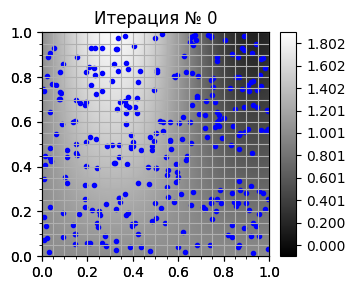

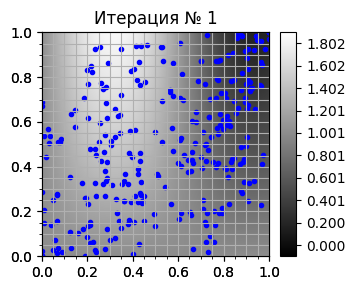

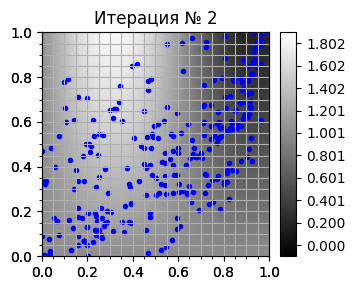

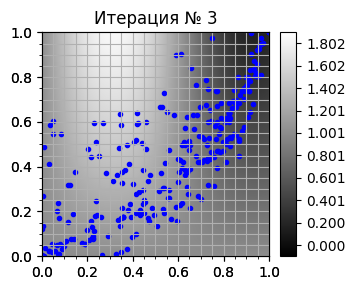

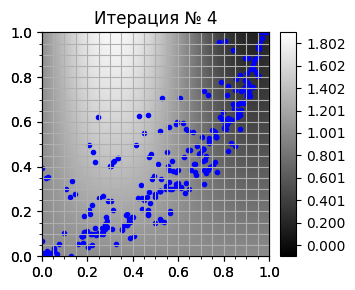

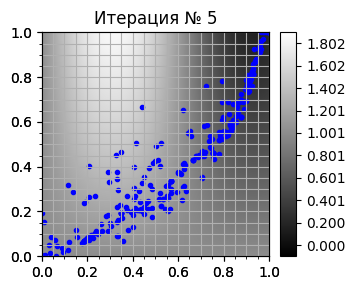

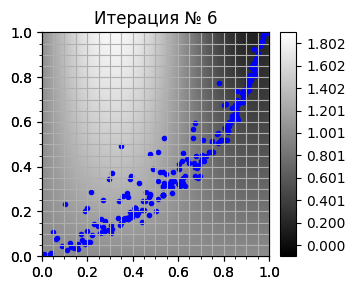

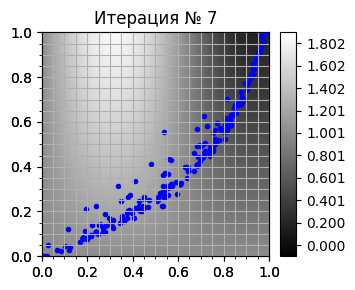

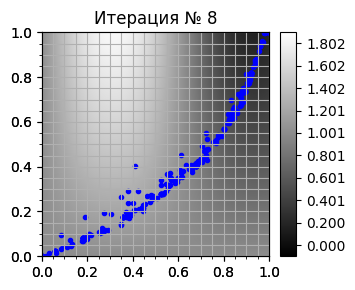

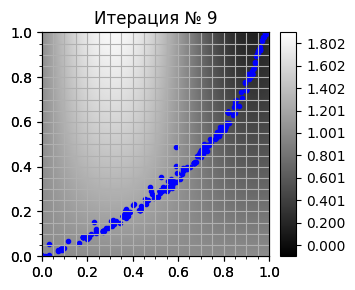

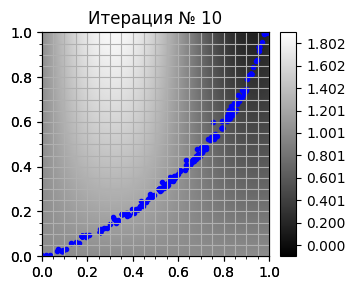

In [ ]:
drawing_the_result(bats_x, bats_y, -1)
for i in range(num_of_iter):
  cur_loc_x, cur_loc_y = bat_algo()
  drawing_the_result(cur_loc_x, cur_loc_y, i)


In [ ]:
nodes = []
interp_nodes = []
for i in range(num_of_agents):
  nodes.append((float('{:.5f}'.format(cur_loc_x[i])), float('{:.5f}'.format(cur_loc_y[i]))))
sorted_nodes = sorted(nodes)

q = round(num_of_agents*0.01)
interp_nodes = []
for i in range(0, num_of_agents, round(num_of_agents / q)):
  interp_nodes.append(sorted_nodes[i])
interp_nodes.append((1, 1))

interp_x = []
interp_y = []
for item in interp_nodes:
  interp_x.append(item[0])
  interp_y.append(item[1])
cost = 0
for i in range(1, len(interp_x)):
  cost += ifoc(interp_x[i], interp_y[i], interp_x[i-1], interp_y[i-1])
print(f"Стоимость строительства: {cost}")
#print(interp_nodes)
#print(interp_x)
#print(interp_y)

Стоимость строительства: 1.2260034086832814


In [ ]:
# Метод неопределённых коэффициентов
x = Symbol('x', real=True)
right_part = np.array(interp_y)
matrix = []
for i in range(len(interp_x)):
  line = []
  for j in range(len(interp_x)):
    line.append(float('{:.5f}'.format(interp_x[i]**j)))
  matrix.append(line)
coeff = np.linalg.solve(np.array(matrix), right_part).tolist()
equation = 0
for i in range(len(interp_x)):
  equation += float('{:.4f}'.format(coeff[i]))*x**i
#print(equation)

In [ ]:
# Метод неопределённых коэффициентов
interp_x = [0, 0.0385, 0.0769, 0.1154, 0.1538, 0.1923, 0.2308, 0.2692, 0.3077, 0.3462, 0.3846, 0.4231, 0.4615, 0.5000, 0.5385, 0.5769, 0.6154, 0.6538,\
            0.6923, 0.7308, 0.7692, 0.8077, 0.8462, 0.8846, 0.9231, 0.9615, 1.0000]
interp_y = [0, 0.0110, 0.0218, 0.0333, 0.0453, 0.0588, 0.0728, 0.0880, 0.1058, 0.1228, 0.1424, 0.1635, 0.1859, 0.2103, 0.2363, 0.2645, 0.2956, 0.3282, \
            0.3668, 0.4061, 0.4532, 0.5087, 0.5739, 0.6533, 0.7500, 0.8526, 1.0000]
x = Symbol('x', real=True)
right_part = np.array(interp_y)
matrix = []
for i in range(len(interp_x)):
  line = []
  for j in range(len(interp_x)):
    line.append(float('{:.5f}'.format(interp_x[i]**j)))
  matrix.append(line)
coeff = np.linalg.solve(np.array(matrix), right_part).tolist()
equation = 0
for i in range(len(interp_x)):
  equation += float('{:.4f}'.format(coeff[i]))*x**i
print(equation)

27916.9079*x**26 - 60463.1824*x**25 + 72586.043*x**24 - 79297.1236*x**23 + 9345.4251*x**22 + 49288.3413*x**21 - 21947.768*x**20 + 17111.1684*x**19 + 2204.5542*x**18 - 25609.5115*x**17 + 14327.0735*x**16 - 9711.0049*x**15 - 6621.7659*x**14 + 10313.5675*x**13 + 4202.2214*x**12 - 1781.9233*x**11 - 1565.9653*x**10 - 743.7264*x**9 + 160.8393*x**8 + 307.3307*x**7 - 9.5503*x**6 + 7.3863*x**5 - 26.2254*x**4 + 8.3083*x**3 - 0.7203*x**2 + 0.3005*x


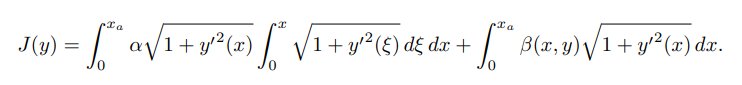

In [ ]:
eq_diff = sp.diff(equation)
print(eq_diff)
mult_one = quad(alpha * sp.sqrt(1 + eq_diff ** 2), 0, 1) [0]
print(mult_one)

725839.6054*x**25 - 1511579.56*x**24 + 1742065.032*x**23 - 1823833.8428*x**22 + 205599.3522*x**21 + 1035055.1673*x**20 - 438955.36*x**19 + 325112.1996*x**18 + 39681.9756*x**17 - 435361.6955*x**16 + 229233.176*x**15 - 145665.0735*x**14 - 92704.7226*x**13 + 134076.3775*x**12 + 50426.6568*x**11 - 19601.1563*x**10 - 15659.653*x**9 - 6693.5376*x**8 + 1286.7144*x**7 + 2151.3149*x**6 - 57.3018*x**5 + 36.9315*x**4 - 104.9016*x**3 + 24.9249*x**2 - 1.4406*x + 0.3005


ValueError: invalid callable given

<ipython-input-54-7edca68fff23>:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


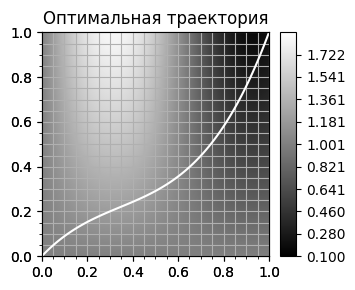

In [ ]:
def drawing_the_line(func):
  xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
  xg = np.linspace(0, 1, 100)
  fig, ax = plt.subplots()
  fig.set_figwidth(3)
  fig.set_figheight(3)
  ax = fig.add_subplot()
  ax.set_title(f"Оптимальная траектория")
  ax.grid()
  plt.axis([0, 1, 0, 1])
  plt.grid(which='major', linestyle='-')
  plt.grid(which='minor', linestyle='-')
  plt.minorticks_on()

  yg = [func.subs(x, i) for i in xg]
  plt.plot(xg, yg, 'w-')
  im = ax.contourf(xx, yy, beta(xx, yy), np.linspace(0.1, 1.9, 1000), cmap="gray")
  #ax.scatter(interp_x, interp_y, marker=".", color='blue')
  axins = inset_axes(ax,
                  width="7%",
                  height="100%",
                  loc='lower left',
                  bbox_to_anchor=(1.05, 0., 1, 1),
                  bbox_transform=ax.transAxes,
                  borderpad=0,
                  )
  plt.colorbar(im, cax=axins)
  plt.tight_layout()
  plt.show()

drawing_the_line(equation)

Расчет стоимости строительства дороги
